# Bayesian Linear Regression with PYMC3
https://stackoverflow.com/questions/37312817/pymc3-bayesian-linear-regression-prediction-with-sklearn-datasets

In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats, optimize
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from theano import shared

np.random.seed(9)

%matplotlib inline

In [3]:
#Load the Data
diabetes_data = load_diabetes()
X, y_ = diabetes_data.data, diabetes_data.target

In [4]:
#Split Data
X_tr, X_te, y_tr, y_te = train_test_split(X,y_,test_size=0.25, random_state=0)

#Shapes
X.shape, y_.shape, X_tr.shape, X_te.shape
#((442, 10), (442,), (331, 10), (111, 10))

((442, 10), (442,), (331, 10), (111, 10))

In [5]:
#Preprocess data for Modeling
shA_X = shared(X_tr)

In [7]:
#Generate Model
linear_model = pm.Model()

In [8]:
with linear_model: 
    # Priors for unknown model parameters    
    alpha = pm.Normal("alpha", mu=0,sd=10)
    betas = pm.Normal("betas", mu=0,#X_tr.mean(), 
                               sd=10, 
                               shape=X.shape[1])
    sigma = pm.HalfNormal("sigma", sd=1)

    # Expected value of outcome
    mu = alpha + np.array([betas[j]*shA_X[:,j] for j in range(X.shape[1])]).sum()

    # Likelihood (sampling distribution of observations)
    likelihood = pm.Normal("likelihood", mu=mu, sd=sigma, observed=y_tr)

    # Obtain starting values via Maximum A Posteriori Estimate
    map_estimate = pm.find_MAP(model=linear_model, fmin=optimize.fmin_powell)

    # Instantiate Sampler
    step = pm.NUTS(scaling=map_estimate)

    # MCMC
    trace = pm.sample(1000, step, start=map_estimate, progressbar=True, njobs=1)

/opt/conda/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


TypeError: minimize() got an unexpected keyword argument 'fmin'

# Bayesian Logistic Regression
https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a

In [9]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano.tensor as tt
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from sklearn.metrics import confusion_matrix

In [11]:
df=pd.read_csv('datatest.txt')
df.sample(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1027,2015-02-03 05:06:00,20.39,22.500,0.0,438.00,0.003327,0
2626,2015-02-04 07:45:00,20.55,23.945,415.5,493.25,0.003577,1
2108,2015-02-03 23:06:59,20.89,25.290,0.0,566.75,0.003860,0
577,2015-02-02 21:36:00,20.89,22.840,0.0,481.50,0.003484,0
2430,2015-02-04 04:28:59,20.70,24.500,0.0,473.50,0.003695,0


In [12]:
df['date']=pd.to_datetime(df['date'])

In [13]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [14]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


In [15]:
df['date'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    2665
unique                   2665
top       2015-02-02 14:19:00
freq                        1
first     2015-02-02 14:19:00
last      2015-02-04 10:43:00
Name: date, dtype: object

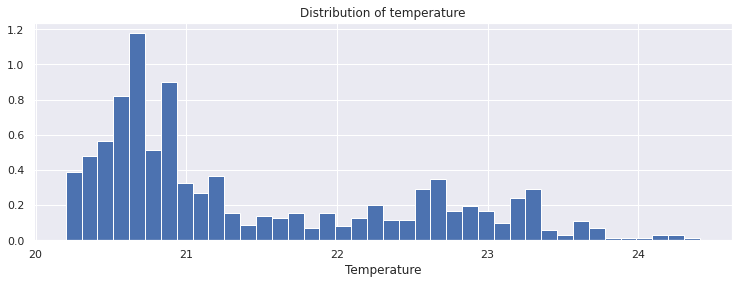

In [16]:
figsize(12.5, 4)
plt.hist(df['Temperature'], bins=40, density=True, label='Temperature')
plt.xlabel('Temperature')
plt.title('Distribution of temperature')
plt.show()

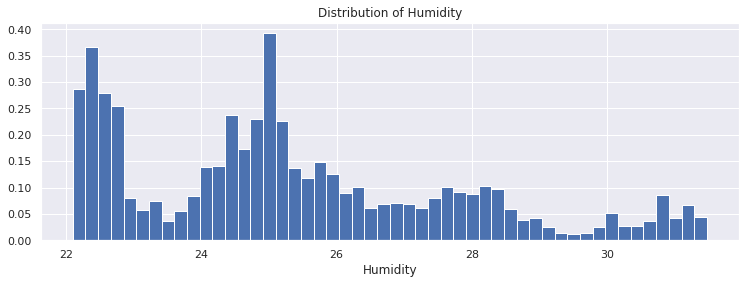

In [17]:
figsize(12.5, 4)
plt.hist(df['Humidity'], bins=50, density=True, label='Humidity')
plt.xlabel('Humidity')
plt.title('Distribution of Humidity')
plt.show()

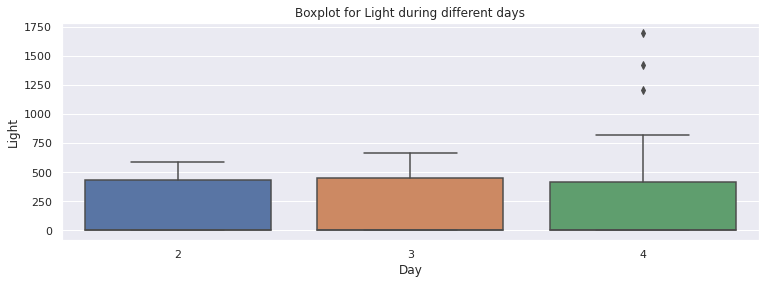

In [18]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['Light'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for Light during different days')
plt.show()

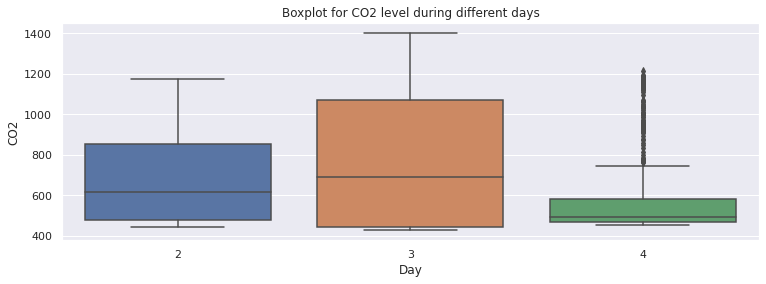

In [19]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['CO2'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for CO2 level during different days')
plt.show()

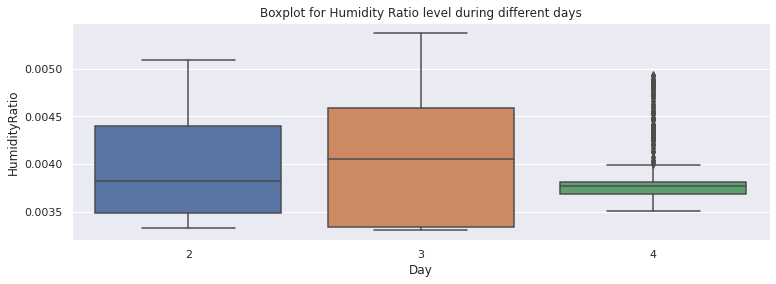

In [20]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['HumidityRatio'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for Humidity Ratio level during different days')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


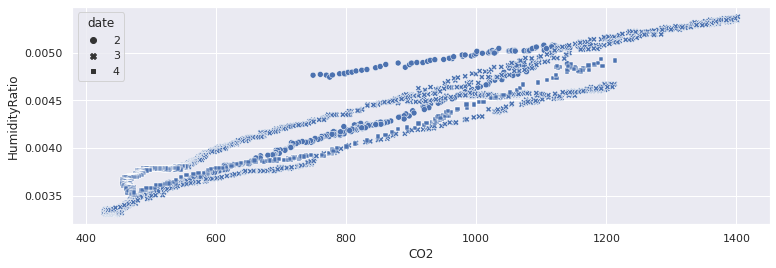

In [21]:
ax=sns.scatterplot(df['CO2'], df['HumidityRatio'], style=df['date'].dt.day)

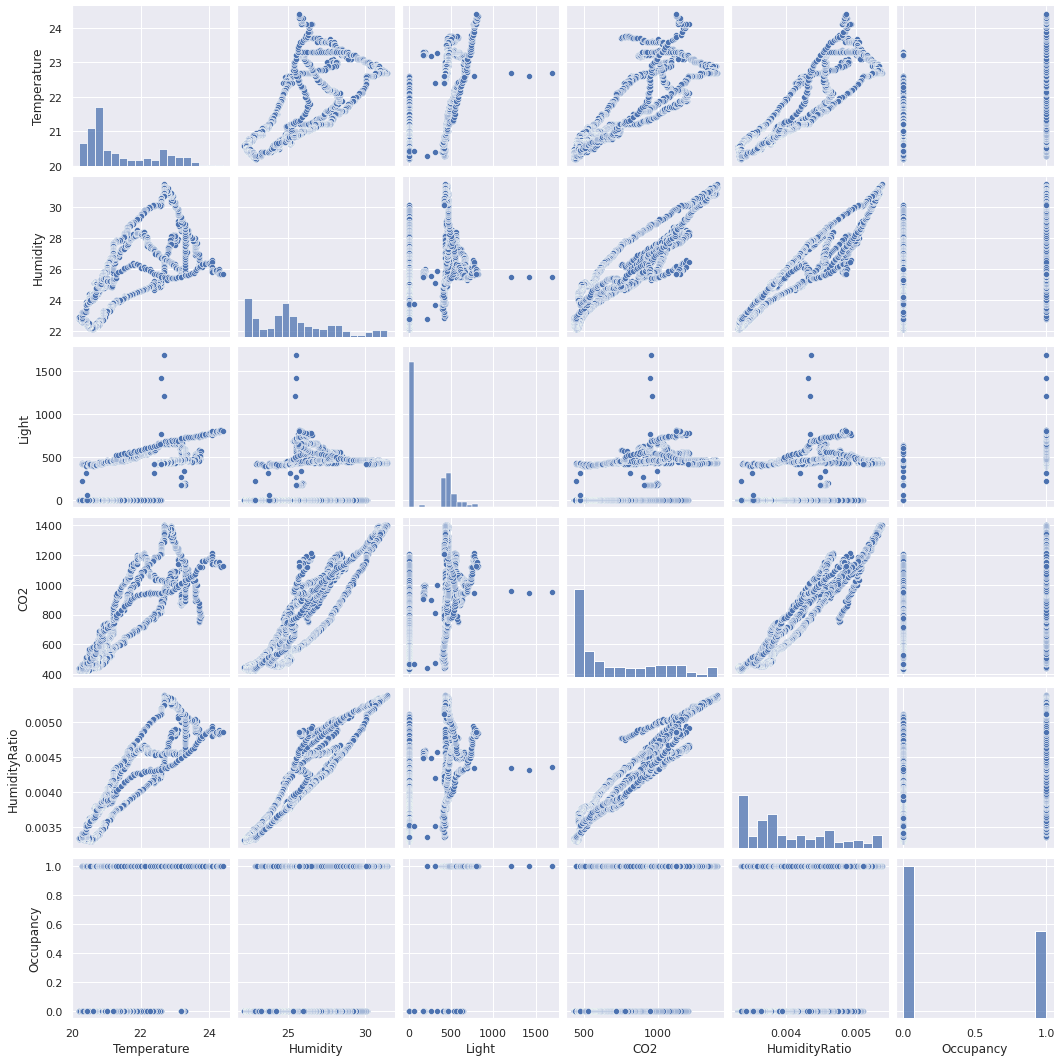

In [22]:
ax=seaborn.pairplot(df)

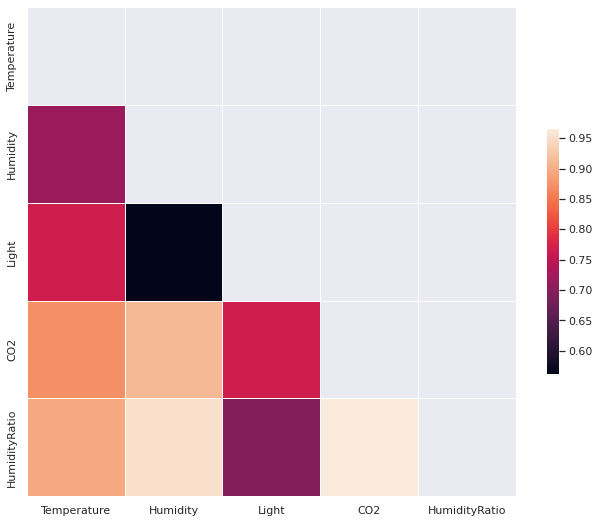

In [23]:
corr=df.iloc[:, 1:-1].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
ax=sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [24]:
lower=-10**6
higher=10**6

In [25]:
with pm.Model() as first_model:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=lower, upper= higher)
    beta_temp=pm.Uniform('beta_temp', lower, higher)
    beta_humid=pm.Uniform('beta_humid', lower, higher)
    beta_light=pm.Uniform('beta_light', lower, higher)
    beta_co2=pm.Uniform('beta_co2', lower, higher)
    beta_humid_ratio=pm.Uniform('beta_humid_ration', lower, higher)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_temp*df['Temperature']+
                               beta_humid*df['Humidity']+
                               beta_light*df['Light']+
                               beta_co2*df['CO2']+
                               beta_humid_ratio*df['HumidityRatio']))
    

In [26]:
with first_model:
    #fit the data 
    observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    burned_trace=trace[15000:]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_humid_ration]
>Metropolis: [beta_co2]
>Metropolis: [beta_light]
>Metropolis: [beta_humid]
>Metropolis: [beta_temp]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
pm.traceplot(burned_trace)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
